# Bayesian workflow {#sec_bayesian_workflow}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os
import logging

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from cmdstanpy import cmdstan_path, CmdStanModel
import cmdstanpy
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

# Configuration
seed = sum(map(ord, "stan_prediction"))
rng = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

## Introduzione

L'applicazione dell'inferenza bayesiana alla risoluzione di problemi reali richiede al ricercatore non solo una solida competenza statistica, una conoscenza approfondita del dominio applicativo e abilità di programmazione, ma anche una profonda comprensione del processo decisionale nel contesto dell'analisi dei dati. Oltre all'inferenza, il workflow comprende la costruzione iterativa di modelli, la verifica, la validazione e la risoluzione di problemi computazionali, la comprensione dei modelli e il confronto tra modelli.

La regola di Bayes, sintetizzata dalla formula

$$
\underbrace{p(\theta|y)}_\text{posteriore} \propto \underbrace{p(y | \theta)}_{\text{likelihood}}  \underbrace{p(\theta)}_{\text{prior}} ,
$$

costituisce il fondamento dell'inferenza bayesiana. Tuttavia, l'applicazione di tale regola in contesti reali richiede un approccio strutturato e iterativo. Nel caso in cui qualcosa vada storto, è necessario prendere decisioni relative alla revisione e al miglioramento del modello. Ecco perché abbiamo bisogno del workflow bayesiano.

## Principi del workflow bayesiano

I workflow esistono in una varietà di discipline dove definiscono cosa costituisce una "buona pratica".

### Il ciclo di Box

Negli anni '60, lo statistico Box formulò il concetto di un ciclo per comprendere la natura del metodo scientifico. Questo ciclo è chiamato il *ciclo di Box* da Blei et. al. (2014):

![](../../figures/boxes_loop.png)

### Workflow bayesiano moderno

Una revisione sistematica dei passi all'interno del moderno workflow bayesiano, descritto in {cite}`gelman2020bayesian`:

![](../../figures/bayes_workflow.png)

### Verifiche predittive a priori

Le verifiche predittive a priori consistono nel simulare dati dai priori. Queste simulazioni vengono comunemente visualizzate (specialmente quando sono coinvolti trasformazioni dei parametri). Questo mostra l'intervallo di dati compatibile con il modello, aiuta a comprendere l'adeguatezza dei priori scelti, poiché è spesso più facile ottenere conoscenza esperta su quantità di interesse misurabili piuttosto che su valori di parametri astratti.

### Verifiche predittive a posteriori

Le verifiche predittive a posteriori consistono nel simulare nuovi dati a partire dalla distribuzione predittiva posteriore. In altre parole, dopo aver stimato i parametri del modello sulla base dei dati osservati, utilizziamo questi parametri per generare nuovi dataset che potrebbero essere stati osservati.

Le verifiche predittive a posteriori sono importanti perché, confrontando i dati simulati con quelli osservati, possiamo valutare se il modello è in grado di generare dati simili a quelli reali. Se le discrepanze sono notevoli, potrebbe essere necessario rivedere le assunzioni del modello. Inoltre, le verifiche predittive a posteriori ci danno un'idea della incertezza nelle nostre predizioni. Possiamo calcolare intervalli di credibilità per le nuove osservazioni, fornendo una misura della nostra fiducia nelle previsioni.

## Costruzione iterativa del modello

Una possibile realizzazione del ciclo del workflow bayesiano:

- Comprendere il dominio e il problema,
- Formulare matematicamente il modello,
- Implementare il modello, testare, debuggare,
- Debuggare, debuggare, debuggare.
- Eseguire verifiche predittive a priori,
- Adattare il modello,
- Valutare i diagnostici di convergenza,
- Eseguire verifiche predittive posteriori,
- Migliorare iterativamente il modello: da modelli di base a modelli complessi ed efficienti dal punto di vista computazionale.

## Esempi

## Coin tossing 

### Data

In [2]:
n = 100    # number of trials
h = 61     # number of successes
alpha = 2  # hyperparameters
beta = 2

niter = 1000

### Model

```{margin}
Note `h=None` here. If we pass data for `h`, inference will be performed by conditioning on this data. Otherwise we will obtain prior predictive samples.
```

In [3]:
def model(n, alpha=2, beta=2, h=None):

    # prior on the probability of success p
    p = numpyro.sample('p', dist.Beta(alpha, beta))

    # likelihood - notice the `obs=h` part
    # p is the probabiity of success,
    # n is the total number of experiments
    # h is the number of successes
    numpyro.sample('obs', dist.Binomial(n, p), obs=h)

### Prior Predictive check

In [4]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# use the Predictive class to generate predictions.
# Notice that we are not passing observation `h` as data.
# Since we have set `h=None`, this allows the model to make predictions of `h`
# when data for it is not provided.
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, n)

In [5]:
# we have generated samples for two variables
prior_predictions.keys()

dict_keys(['obs', 'p'])

In [6]:
# extract samples for variable 'p'
pred_obs = prior_predictions['p']

# compute its summary statistics for the samples of `p`
mean_prior_pred = jnp.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

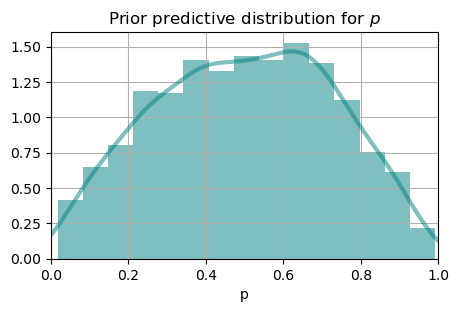

In [7]:
fig = plt.figure(dpi=100, figsize=(5, 3))
plt.hist(pred_obs, bins=15, density=True, alpha=0.5, color='teal')
x = jnp.linspace(0, 1, 3000)
kde = gaussian_kde(pred_obs)
plt.plot(x, kde(x), color='teal', lw=3, alpha=0.5)
plt.xlabel('p')
plt.title('Prior predictive distribution for $p$')
plt.xlim(0, 1)
plt.grid(0.3)
plt.show()

### Inference

Using the same routine as we did for prior predictive, we can perform inference by using the observed data.

In [8]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# specify inference algorithm
kernel = NUTS(model)

# define number of samples and number chains
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, progress_bar=False)

<ipython-input-8-c44db27e98a6>:8: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, progress_bar=False)


In [9]:
#run MCMC
mcmc.run(rng_key_, n=n, h=h)

In [10]:
# extract samples of parameter p
p_samples = mcmc.get_samples()
p_posterior_samples = p_samples['p']

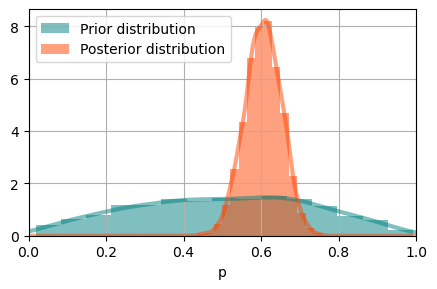

In [11]:
fig = plt.figure(dpi=100, figsize=(5, 3))
plt.hist(pred_obs, bins=15, density=True, alpha=0.5, color='teal', label = "Prior distribution")
plt.hist(p_posterior_samples, bins=15, density=True, alpha=0.5, color='orangered', label = "Posterior distribution")
x = jnp.linspace(0, 1, 3000)
kde = gaussian_kde(pred_obs)
plt.plot(x, kde(x), color='teal', lw=3, alpha=0.5)
kde = gaussian_kde(p_posterior_samples)
plt.plot(x, kde(x), color='orangered', lw=3, alpha=0.5)
plt.xlabel('p')
plt.xlim(0, 1)
plt.grid(0.3)
plt.legend()
plt.show()

### Check convergence

We now have obtained the samples from MCMC. How can we assess whether we can trust the results? Convergence diganostics survey this purpose. Beyond $\hat{R}$, we can also visually inspect traceplots. Traceplots are simply sample values plotted against the iteration number. We want those traceplots to be stationary, i.e. they should look like a "hairy carterpillar".

In [12]:
# inpect summary
# pring summary and look at R-hat
# r_hat is a dignostic comparing within chain variation to between chan variation.
# It is an importnat convergene diagnostic, and we want its valye to be close to 1
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.61      0.05      0.61      0.53      0.68   3059.08      1.00

Number of divergences: 0


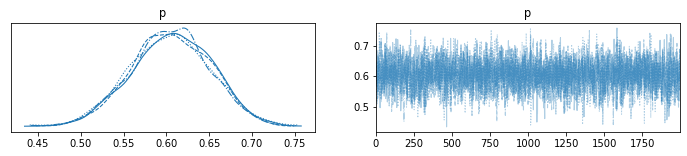

In [13]:
# plot posterior distribution and traceplots
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

### Posterior predictive distribution

The <font color='orange'>posterior predictive</font> distribution is a concept in Bayesian statistics that combines the information from both the observed data and the posterior distribution of model parameters to <font color='orange'>generate predictions for new, unseen data</font> .

We can use the obtained samples obtained at the previous step to generate posterior predictive distribution on the outcome.

In [14]:
# using the same 'Predictive' class,
# but now specifying also `p_samples`
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, p_samples)
posterior_predictions = predictive(rng_key_, n=n)

In [15]:
# extract prediction and calculate summary statistics
post_obs = posterior_predictions['obs']
mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

In [16]:
# what is the mean number of successes?
mean_post_pred

Array(60.508003, dtype=float32)

In [17]:
# what is the unceratinty around this mean?
hpdi_post_pred

array([48, 70], dtype=int32)

`````{admonition} Group Task
- Change the hyperparameters of the model. How are they changing the results?
- Change the data to `n=10`, `h=6`. How does the result change now?

`````